In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
resident_foreigners_norm = pd.read_table("Data_norm/resident_foreigners_norm.csv", sep = ",", 
                                         usecols = ['Provincia', 'Cittadinanza','Periodo', 'Sesso', 'Numero'])
resident_foreigners_norm.head()

,Provincia,Cittadinanza,Periodo,Sesso,Numero
0,Alessandria,Andorra,2017,maschi,0
1,Alessandria,Andorra,2017,femmine,1
2,Genova,Andorra,2013,maschi,0
3,Genova,Andorra,2013,femmine,1
4,Como,Andorra,2013,maschi,0


In [27]:
provincia_regione = pd.read_table("Data/regioni.csv", sep = "\t")
provincia_regione.head()

,Provincia,Regione
0,Torino,Piemonte
1,Vercelli,Piemonte
2,Novara,Piemonte
3,Cuneo,Piemonte
4,Asti,Piemonte


In [28]:
regione_zona = pd.read_table("Data/territori.csv", sep = "\t")
regione_zona.head()

,Regione,Zona
0,Abruzzo,Sud
1,Basilicata,Sud
2,Calabria,Sud
3,Campania,Sud
4,Emilia-Romagna,Nord-est


In [38]:
years = sorted(list(set(resident_foreigners_norm["Periodo"])))
maschi = [sum(resident_foreigners_norm[(resident_foreigners_norm["Sesso"] == "maschi") 
                                       & (resident_foreigners_norm["Periodo"] == y)]["Numero"]) for y in years]
femmine = [sum(resident_foreigners_norm[(resident_foreigners_norm["Sesso"] == "femmine") 
                                       & (resident_foreigners_norm["Periodo"] == y)]["Numero"]) for y in years]
totale = [i+j for i, j in zip(maschi, femmine)]

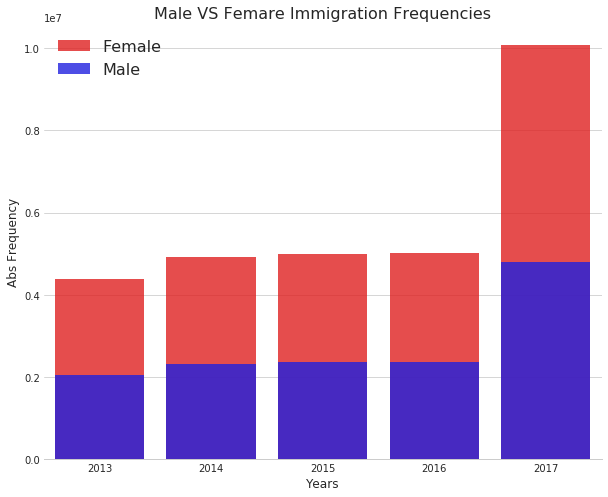

In [89]:
#Set general plot properties
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (10, 8)})

fig, ax = plt.subplots()
sns.barplot(y= totale, x = years, label = "Female",  color="r", alpha = .8)
sns.barplot(y= maschi, x = years, label = "Male",  color="b", alpha = .8)
sns.despine(left=True)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Abs Frequency", fontsize=12)
plt.legend(prop={'size':16})
plt.title("Male VS Femare Immigration Frequencies", fontsize = 16)
#plt.xticks(rotation=45)

plt.show()

In [169]:
# Region distribution - aggragation over the year
regioni = {}

for r in regioni.keys():
    regioni[r] = sum([sum(resident_foreigners_norm[resident_foreigners_norm["Provincia"] == i]["Numero"].values) for i in provincia_regione[provincia_regione["Regione"] == r]["Provincia"].values])

In [216]:
# Region distribution across the years
regioni = {}

for r in list(set(regione_zona["Regione"])):
    regioni[r] = {y: sum([sum(resident_foreigners_norm[(resident_foreigners_norm["Provincia"] == i) 
                                                          & (resident_foreigners_norm["Periodo"] == y)]["Numero"].values) 
                             for i in provincia_regione[provincia_regione["Regione"] == r]["Provincia"].values]) 
                  for y in years}

In [ ]:
# Plot it!

In [218]:
# Zone distribution across the years
zone = {}

for z in list(set(regione_zona["Zona"])):
    zone[z] = {y: sum([regioni[t][y] for t in temp]) for y in years}

In [ ]:
# Plot it!

Missing data seems to be balanced between the different informatio:

In [106]:
# how many elements each year should have - *2(maschi-femmine)
len(list(set(resident_foreigners_norm["Cittadinanza"])))*len(list(set(resident_foreigners_norm["Territorio"])))*2

missing_across_years = [len(resident_foreigners_norm[(resident_foreigners_norm["Periodo"] == y)]) for y in years]

missing_across_territories = [len(resident_foreigners_norm[(resident_foreigners_norm["Territorio"] == t)]) 
                        for t in list(set(resident_foreigners_norm["Territorio"]))]
